In [1]:
# from openai import OpenAI
# import os
# from dotenv import load_dotenv

# # Load values from the .env file if it exists
# load_dotenv()

# # Configure OpenAI
# key = os.getenv("OPENAI_API_KEY")

# client = OpenAI(api_key=key)

# # Define function to get chatbot response
# def get_chatbot_response(prompt):
#    chat_completion = client.chat.completions.create(
#     messages=[
#         {
#             "role": "user",
#             "content" : prompt,
#         }
#     ],
#     model="gpt-3.5-turbo",
# )
#    print(chat_completion.choices[0].message.content)
#    return chat_completion.choices[0].message.content

# # Define function to get chatbot response for a given input string
# def get_response(input_string):
#     return get_chatbot_response(input_string)


In [1]:
import os
import sys
import numpy as np
import cv2
import time
from imutils.object_detection import non_max_suppression

def east_detect(image, net):
    layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
    orig = image.copy()

    if image.ndim == 2:  # Use ndim instead of len(shape)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    (H, W) = image.shape[:2]
    # Example adjustment, actual optimal values may vary
    newW, newH = 640, 320
    
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    
   
    print("EAST:" + str(time.time() - start))
    time_stamp = time.time() - start
    if len(rects) > 0:
        print(confidences)
        boxes_1 = non_max_suppression(np.array(rects), probs=confidences)
        
        
        boxes_1 = np.array(boxes_1)  # Convert to a NumPy array

        # Now you can use NumPy array indexing and sorting operations
        boxes_indices = np.lexsort((boxes_1[:, 0], boxes_1[:, 1]))  # Now it should work

        # Apply sorted indices to the array
        boxes = boxes_1[boxes_indices]        
        cropped_images = []  # List to hold cropped images
        keys = []

        for (startX, startY, endX, endY) in boxes:
            copy = orig.copy()
            startX = int(startX * rW - 10)
            startY = int(startY * rH - 10)
            endX = int(endX * rW + 10 )
            endY = int(endY * rH + 10)
            cv2.rectangle(copy, (startX, startY), (endX, endY), (0, 255, 0), 2)

            # Crop and save each detected region
            cropped_region = copy[startY:endY, startX:endX]
            cropped_images.append(cropped_region)
            new_key = str(startX) + str(startY) + str(endX) + str(endY)
            keys.append(new_key)
            
       
        return orig, cropped_images, keys
    return None, rects, None

# Example usage
# image = cv2.imread("a-sign-big.jpg")
# detected_image, cropped_texts = east_detect(image)
# for i, cropped in enumerate(cropped_texts):
#     cv2.imshow(f"Cropped Text {i+1}", cropped)
#     text = read_image(cropped)
  
# # cv2.imshow("Detected Text", detected_image)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()






In [2]:
   if len(rects) > 0:

        print(confidences)
        boxes_1 = non_max_suppression(np.array(rects), probs=confidences)


        boxes_1 = np.array(boxes_1)  # Convert to a NumPy array

        # Now you can use NumPy array indexing and sorting operations
        boxes_indices = np.lexsort((boxes_1[:, 0], boxes_1[:, 1]))  # Now it should work

        # Apply sorted indices to the array
        boxes = boxes_1[boxes_indices]

NameError: name 'rects' is not defined

In [2]:


import pytesseract
from PIL import Image
from pytesseract import Output
def read_image(image):
  
    tess_dict = pytesseract.image_to_string(image,  output_type=Output.DICT)
    print(tess_dict['text'])
    if tess_dict['text'] != '' or tess_dict['text'].strip() != "":
        
        print(tess_dict)
        text = tess_dict['text']
        confidence = tess_dict['conf']
    else: 
        confidence = None
        text = None
        
        return confidence, text





In [4]:

def add_to_records(records_dict, response, text):
    records_dict[text] = response
    return records_dict



In [5]:
def append_to_file(data_to_append):
    """
    Appends data to a file. Creates the file if it doesn't exist.

    Args:
    file_path (str): The path to the file.
    data_to_append (str): The data to append to the file.
    """
    try:
        # Open the file in append mode, which creates the file if it doesn't exist
        with open('response.txt', 'a') as file:
            file.write(data_to_append)
        print(f"Data appended to successfully.")
    except IOError as e:
        print(f"An error occurred while writing: {e}")

In [8]:
import cv2
import pytesseract
import numpy as np
from pytesseract import Output

path_to_image = 'lebron_james.jpg'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load the network model outside of the function to avoid reloading it on each call
net = cv2.dnn.readNet("frozen_east_text_detection.pb")

img_source = cv2.imread(path_to_image)
cv2.imwrite('sample_output.jpg', img_source)


def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def thresholding(image):

    binary_image = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 11, 2)

    return binary_image

def opening(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


def canny(image):
    return cv2.Canny(image, 100, 200)

def text_detection_image(path_to_image, image):
    # print("Processing image...")
    out_image, cropped, keys  = east_detect(image, net)
    imageName = path_to_image.split('/')[-1]
    imageName = path_to_image.split('.')[0]
    
  
    if out_image is not None and len(cropped) > 0:
        for i in range(len(cropped)):
            print(len(cropped  ))
            imageName = path_to_image.split('/')[-1]
            new_path = f"results/sample_output-{imageName}-east-{i}.jpg"
            cv2.imwrite(new_path, cropped[i])
        
        new_path = f"results/sample_output-{imageName}-east.jpg"
        cv2.imwrite(new_path, out_image)
        
        return cropped, keys 
    return cropped
    

Full_Text = {}

current_test = ""
current_max_confidence = 0
cropped, keys = text_detection_image(path_to_image, img_source)
cropped.append(img_source)
keys.append('original')

for j in range(len(cropped)):
    gray = get_grayscale(cropped[j])
    thresh = thresholding(cv2.GaussianBlur(get_grayscale(cropped[j]), (5, 5), 0))
    canny_img = canny(gray)
    opening_img = opening(gray)
    inverse = cv2.bitwise_not(gray)
    for img in [gray, thresh, canny_img, opening_img, inverse]:
        current_max_confidence = 0
        current_text = ""
        custom_config = r'-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklompqstruvwxyz --psm 6'
        d = pytesseract.image_to_data(img, config=custom_config, output_type=Output.DICT)
        n_boxes = len(d['text'])
        

        # back to RGB
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
        count = 0
        for i in range(n_boxes):
                (text, x, y, w, h) = (d['text'][i], d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                # don't show empty text
                if count > 5:
                    break
                
                if text and text.strip() != "":
                    conf = int(d['conf'][i])
                    weighted_confidence = len(text)  * conf   
 
                    if weighted_confidence >= current_max_confidence:
                        if text not in Full_Text:
                            current_max_confidence = weighted_confidence
                            current_text = text
                count += 1
        if current_text not in Full_Text and current_text != "":
            if keys[j] not in Full_Text:
                Full_Text[keys[j]] = {'text': current_text, 'confidence': current_max_confidence}
            else:
                if  Full_Text[keys[j]]['confidence'] < current_max_confidence:
                    Full_Text[keys[j]] = {'text': current_text, 'confidence': current_max_confidence}
                    
total = 0
for k in Full_Text.keys():
    if k != 'original':
        total += Full_Text[k]['confidence']
if total < Full_Text['original']['confidence']:
    Full_Text = {'text': Full_Text['original']['text'], 'confidence': Full_Text['original']['confidence']}
else:
    del Full_Text['original']

print(Full_Text)
        
          

EAST:0.33099937438964844
[0.8991026, 0.99188, 0.9948177, 0.9684299, 0.8974602, 0.9195443, 0.95198625, 0.9949521, 0.9878185, 0.94160837, 0.9980248, 0.99942744, 0.99952507, 0.99957305, 0.9995993, 0.9996537, 0.99971837, 0.99978644, 0.9997999, 0.99981683, 0.9998354, 0.9998605, 0.9998704, 0.9998795, 0.9998665, 0.99988496, 0.9998889, 0.9999113, 0.9999304, 0.9999409, 0.9999491, 0.9999515, 0.99995327, 0.9999567, 0.99996495, 0.9999676, 0.99996614, 0.999948, 0.99985087, 0.9997348, 0.9999161, 0.9999428, 0.9999527, 0.9999511, 0.999954, 0.99995434, 0.99995434, 0.99994993, 0.9999461, 0.99994147, 0.99993396, 0.9999273, 0.9999237, 0.9999279, 0.9999304, 0.99991405, 0.99990344, 0.99988556, 0.9998865, 0.99988997, 0.99988663, 0.99988616, 0.99990237, 0.99991167, 0.9999243, 0.9999316, 0.99994636, 0.99995375, 0.9999578, 0.99994576, 0.9998766, 0.9998338, 0.99993527, 0.9999497, 0.99994075, 0.99991536, 0.9999021, 0.99988186, 0.99985063, 0.99970454, 0.99404126, 0.844536, 0.8576401, 0.58447695, 0.58173746, 0.9008

In [ ]:
import cv2
import pytesseract
from pytesseract import Output

image_path = 'images/metro.jpg'
image = cv2.imread(image_path)

# Check if the image was loaded properly
if image is None:
    print(f"Failed to load image from {image_path}")
else:
    # Assuming pytesseract and Output are imported correctly
    d = pytesseract.image_to_data(image, output_type=Output.DICT)
    print(d["text"])

['', '', '', '', '']


BOXES:  2
EAST:0.2870016098022461


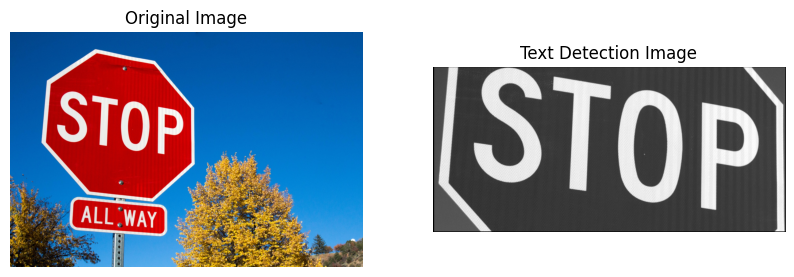

In [ ]:
import cv2
import matplotlib.pyplot as plt

def detect_edges(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce image noise in the grayscale image
    blurred_image = cv2.GaussianBlur(gray_image, (1, 1), 0)
    
    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, 100, 200)
    
    org, cropped = text_detection_image(image_path, blurred_image)
    
    # Display the original image and the edge detected image
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
 
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
    plt.title('Text Detection Image')
    plt.axis('off')
    
    
    plt.show()

# Replace 'path_to_your_street_sign_image.jpg' with the path to the image file you want to process
detect_edges('images/test.jpg')


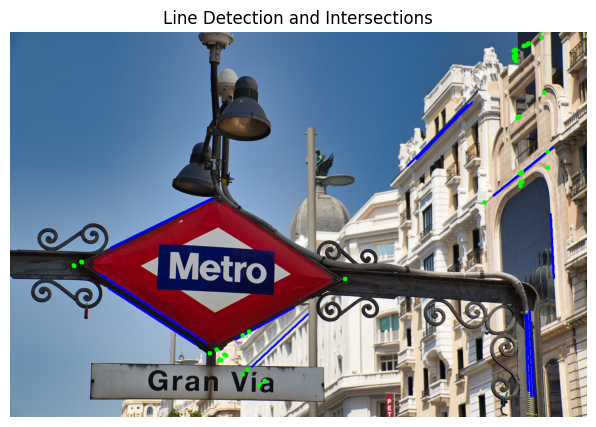

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def line_intersection(line1, line2):
    """Find the intersection of two lines specified by ((x1, y1), (x2, y2))."""
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('Lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def detect_edges_and_lines(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    # Perform Canny edge detection
    edges = cv2.Canny(blurred_image, 50, 100, apertureSize=3)

    # Detect lines in the image using HoughLinesP
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=120, maxLineGap=3)
    
    # Create a copy of the original image to draw lines
    line_image = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 3)

    # Find intersections
    intersections = []
    if lines is not None:
        for i in range(len(lines)):
            for j in range(i + 1, len(lines)):
                line1 = [(lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3])]
                line2 = [(lines[j][0][0], lines[j][0][1]), (lines[j][0][2], lines[j][0][3])]
                try:
                    intersect = line_intersection(line1, line2)
                    if intersect:
                        cv2.circle(line_image, (int(intersect[0]), int(intersect[1])), 5, (0, 255, 0), -1)
                        intersections.append(intersect)
                except Exception as e:
                    pass  # Ignore if lines do not intersect

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    plt.title('Line Detection and Intersections')
    plt.axis('off')
    
    plt.show()

# Replace 'path_to_your_street_sign_image.jpg' with the path to the image file you want to process
detect_edges_and_lines('images/metro.jpg')
